In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 1 2 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 2 1 1 0 0 0 2 1 1]


In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy().shape)

(256, 256, 3)


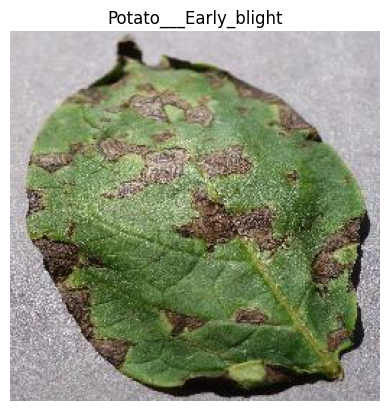

In [8]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [9]:
train_ds = dataset.take(int(round(len(dataset)*0.8,0)))
len(train_ds)

54

In [13]:
def get_dataset_partition(ds,train_split=0.8,test_split=0.2,val_split=0.1,shuffle=True):
    ds_size = len(ds)
    ds.shuffle(ds_size,seed=12)
    train_ds = ds.take(int(len(ds)*train_split))
    test_ds = ds.skip(len(train_ds))
    test_ds = test_ds.skip(int(len(ds)*val_split))
    val_ds = test_ds.take(int(len(ds)*val_split))
    return train_ds,test_ds,val_ds

train_ds,test_ds,val_ds = get_dataset_partition(dataset)

In [14]:
len(test_ds)

8

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =  val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [19]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds,
    callbacks = [early_stopping_callback]
)

Epoch 1/50


54/54 [==============================] - 66s 1s/step - loss: 0.8236 - accuracy: 0.5561 - val_loss: 0.7201 - val_accuracy: 0.6823
Epoch 2/50
54/54 [==============================] - 50s 930ms/step - loss: 0.5854 - accuracy: 0.7338 - val_loss: 0.4803 - val_accuracy: 0.7812
Epoch 3/50
54/54 [==============================] - 49s 900ms/step - loss: 0.4680 - accuracy: 0.7963 - val_loss: 0.4487 - val_accuracy: 0.8021
Epoch 4/50
54/54 [==============================] - 66s 1s/step - loss: 0.3812 - accuracy: 0.8223 - val_loss: 0.8592 - val_accuracy: 0.6823
Epoch 5/50
54/54 [==============================] - 80s 1s/step - loss: 0.3565 - accuracy: 0.8582 - val_loss: 0.2126 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 80s 1s/step - loss: 0.3376 - accuracy: 0.8559 - val_loss: 0.3072 - val_accuracy: 0.8385
Epoch 7/50
54/54 [==============================] - 55s 1s/step - loss: 0.2024 - accuracy: 0.9271 - val_loss: 0.1565 - val_accuracy: 0.9375
Epoch 8/50
5

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training vs Test Accuracy')

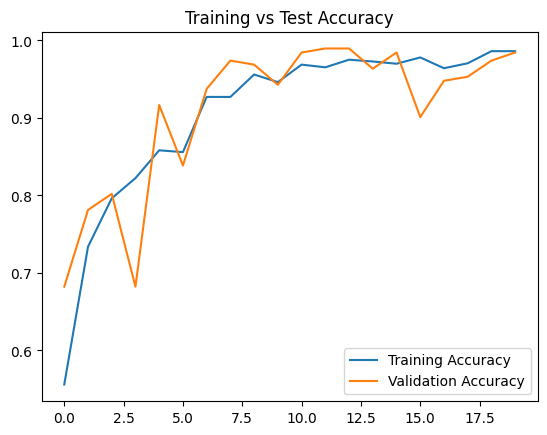

In [25]:
plt.plot(range(20),acc,label='Training Accuracy')
plt.plot(range(20),val_acc,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Test Accuracy')

In [26]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 262ms/step - loss: 0.0628 - accuracy: 0.9741


In [27]:
scores

[0.06278593093156815, 0.9741379022598267]

First Image to be predicted
Actual label:Potato___Late_blight
1/1 [==============================] - 1s 577ms/step
predicted = Potato___Late_blight


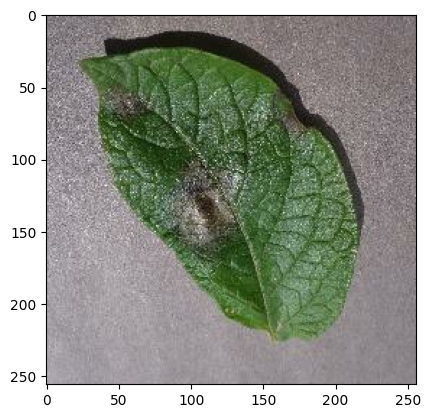

In [28]:
for images_batch,label_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First Image to be predicted")
    plt.imshow(first_image)
    print(f"Actual label:{class_names[first_label]}")

    batch_prediction = model.predict(images_batch)
    print(f"predicted = {class_names[np.argmax(batch_prediction[0])]}")

In [29]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predictions,confidence

1/1 [==============================] - 0s 42ms/step


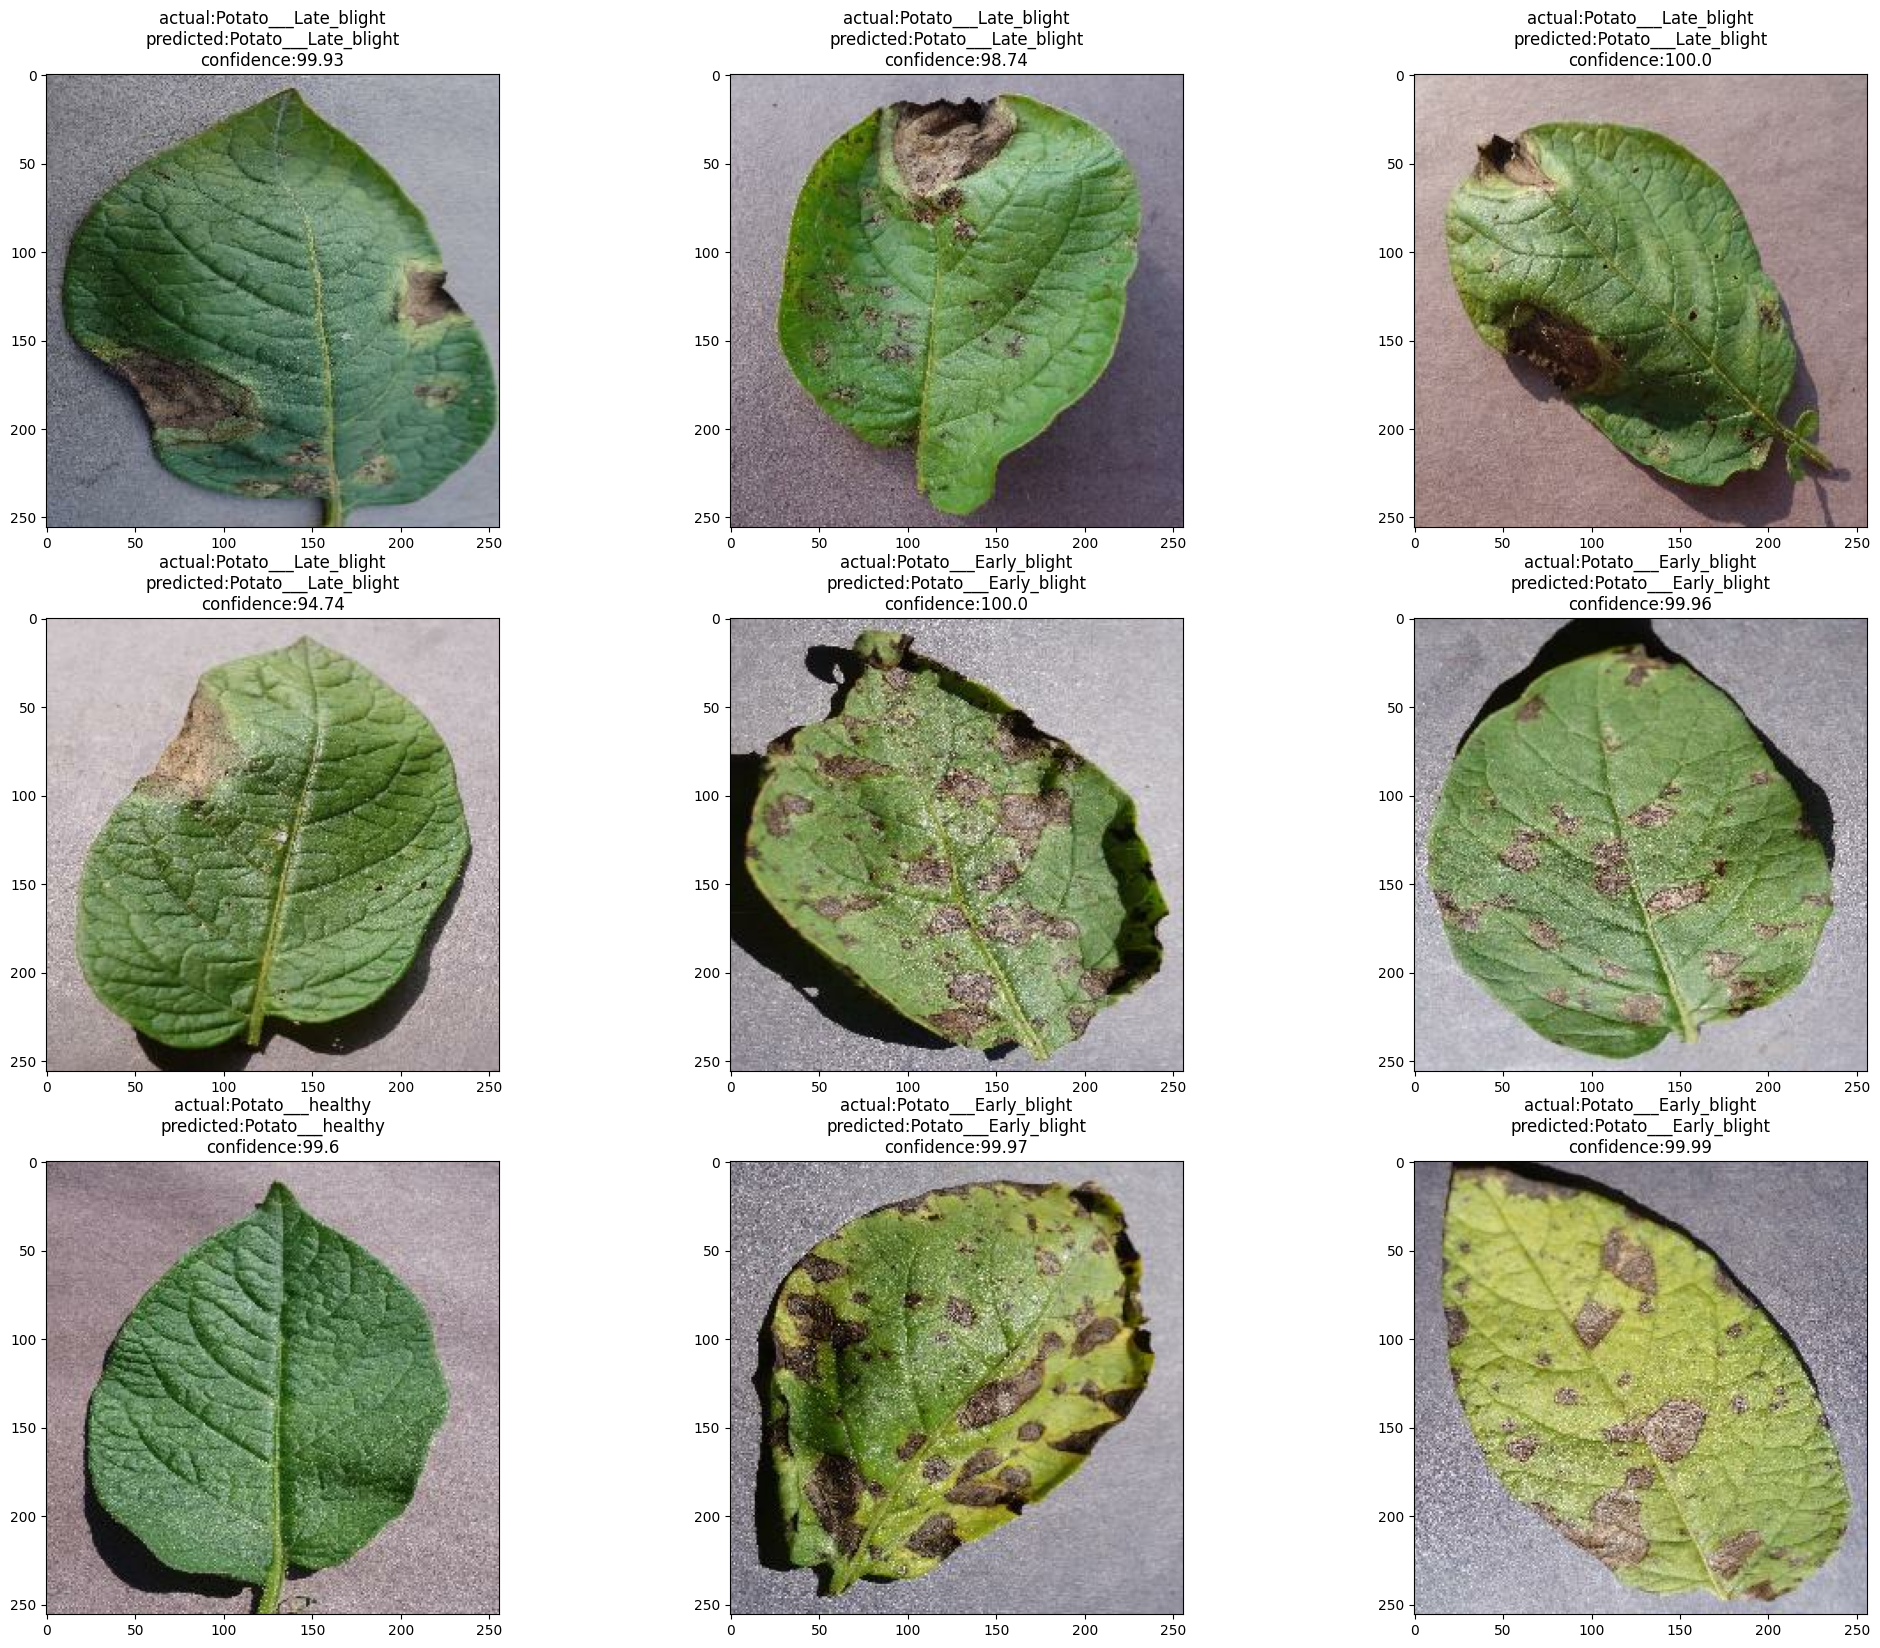

In [30]:
plt.figure(figsize = (25,20))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        predictions,confidence = predict(model,images)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"actual:{class_names[labels[i]]}\npredicted:{class_names[np.argmax(predictions)]}\nconfidence:{confidence}")

In [32]:
model.save("model.h5")

c:\Users\nehap\Downloads\ANN Classification\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
